## Import your stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simulators.faas.simulator as faas
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
import rpy2.robjects.numpy2ri
from rpy2.robjects import rinterface, r, IntVector, FloatVector, StrVector
import logging
logging.getLogger('faas').setLevel(logging.ERROR)
logging.getLogger('delfi').setLevel(logging.ERROR)
rpy2.robjects.numpy2ri.activate()
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
seed = 20

In [2]:
#get batch arguments
batch = 'G'
if batch not in ['A','B','C','D','E','F','G']:
    print("Pass a valid batch letter")

    
batch_ids = {'A':[0,12,'A'],'B':[13,23,'B'],'C':[24,34,'C'],'D':[35,50,'D'],'E':[51,64,'E'],'F':[65,79,'F'],'G':[80,93,'G']}
batch_min, batch_max, let = batch_ids[batch][0], batch_ids[batch][1], batch_ids[batch][2]

## Set up the prior

Last working prior
upper = np.array([7.700001e+08,  8.400001e+07,  3.200001e+10,  2.500001e+07,  1.600001e+05,
  2.600001e+03,  2.200001e+04,  6.500001e+00,  8.886492e+00,  7.924280e+00,
  1.050516e+01,  7.397941e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
 -6.585027e+00,  1.100001e-03, -3.900000e-01])
lower = np.array([7.700000e+08,  8.400000e+07,  3.200000e+10,  2.500000e+07,  1.600000e+05,
  2.600000e+03,  2.200000e+04,  6.500000e+00,  8.886491e+00,  7.924279e+00,
  1.050515e+01,  7.397940e+00, -3.682372e+00, -4.509307e+00, -6.162728e+00,
 -6.585028e+00,  1.100000e-03, -3.900001e-01])

In [3]:
upper = np.array([12,  12,
  12,  12, -2, -2, -2,
 -2])
lower = np.array([6,  6,
  6,  6, -8, -8, -8,
 -8])

prior_mean = np.array([1.1e-03, -3.9e-01])
prior_cov = np.diag(np.array([(0.0011*0.2)**2, (-0.39*0.2)**2]))

prior = priors.Gaussian_Unif(prior_mean, prior_cov, lower, upper, 2)

epsilon_mean = np.array([0]*94)
epsilon_cov = np.diag(np.array([0.1 ** 2] * 94))
epsilon_prior = priors.Gaussian(epsilon_mean, epsilon_cov)

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [4]:
faasSimulator = faas.faas_Model()

## repeating last fratio for short rows
def simulator(theta, seed, simulator_args, batch):

    eps_prior = simulator_args[0]
    eps = eps_prior.draw()

    return faasSimulator.simulation(np.concatenate([theta, eps]), seed)[batch_min:batch_max,1:]

simulator_args = [epsilon_prior]
th1 = [1.17727120e+01,  7.19306846e+00,  6.91596870e+00,  9.22284246e+00,
 -6.02884028e+00, -3.18481951e+00, -3.71367175e+00, -4.51552650e+00,
  1.18899026e-03, -4.48879034e-01]

th2 = [1.14792160e+01,  1.19853470e+01,  6.29772069e+00,  8.20488081e+00,
 -6.72900189e+00, -3.84944990e+00, -5.75709989e+00, -2.19121052e+00,
  1.26303057e-03, -5.49739370e-01]

th3 = [ 6.54617672e+00,  1.19830061e+01,  6.55901082e+00,  7.65031683e+00,
 -5.36489298e+00, -7.81208968e+00, -7.76854311e+00, -5.90468570e+00,
  1.05203390e-03, -3.35132651e-01]

sims = simulator(th3, seed, simulator_args, 0)
print(sims)

[[12.61482887 12.71284934 12.80685528 ... 13.48426477 13.47216764
  13.46264789]
 [15.36321376 15.47323982 15.56351985 ... 18.07471855 18.07446197
  18.07428955]
 [17.04191431 17.14913336 17.25603509 ... 20.37178791 20.37176075
  20.37174505]
 ...
 [22.82099713 22.88296109 22.94058458 ... 25.21797642 25.21797642
  25.21797642]
 [23.12872436 23.22802006 23.3475298  ... 25.55327605 25.55327605
  25.55327605]
 [23.11978001 23.21819524 23.33660475 ... 25.54836952 25.54836952
  25.54836952]]


## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [5]:
def compressor(d, compressor_args):
    comp_d = []

    for i in d:
        #mean of final ten entries
        final = np.mean(i[-10:])
        #median of 3 highest points
        peak = np.median(np.sort(i)[-3:])
        #time to peak
        time_peak = np.argmax(i == peak)
        sd = np.std(i[-10:])
        #time to final
        time_final = np.argmax(np.logical_and((i[time_peak:] >= final - sd),(i[time_peak:] <= final + sd)) == True) + time_peak
        comp_d.append([final, peak, time_peak, time_final])
    return np.asarray(comp_d).flatten()
compressor_args=None




## Load in the compressed data

In [6]:
compressed_data = compressor(faasSimulator.data()[batch_min:batch_max], compressor_args)

ndata = len(compressed_data)

print(compressor(sims, compressor_args))

[ 13.55590487  15.32912957 209.         251.          18.07799536
  18.88121328 212.         250.          20.37266012  20.72177766
 217.         251.          22.00447585  22.12894389 222.
 250.          23.09189562  23.12840087 227.         250.
  22.68277038  22.74341191 231.         250.          23.70099432
  23.71630222 234.         249.          24.68449923  24.68455058
 247.         250.          25.18004636  25.18004636 257.
 257.          24.82975996  24.82977641 245.         250.
  25.21797641  25.21797642 257.         257.          25.55327607
  25.55328087 246.         250.          25.54836954  25.54837457
 246.         250.        ]


## Load in data

In [7]:
data = faasSimulator.data()[:12,:]
print(data.shape)

(12, 259)


## Define ensemble of NDEs

In [8]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=10, n_data=ndata, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=ndata, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [9]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,
                       param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'],
                       results_dir = "results_batch_" + let + "/", save = True)

## Fisher pre-training to initialize the NDEs

## Sequential Neural Likelihood

[ 8.95443663e+00  8.53552834e+00  6.02424793e+00  1.12164408e+01
 -4.87833179e+00 -7.68249719e+00 -4.34889651e+00 -6.73927485e+00
  1.09476947e-03 -2.58998758e-01]
[ 1.02931135e+01  9.40013795e+00  1.18595333e+01  1.10100904e+01
 -4.15410967e+00 -6.16606610e+00 -5.41232812e+00 -4.32166281e+00
  1.24429658e-03 -2.85209296e-01]
[ 1.02330433e+01  7.00079523e+00  1.03746195e+01  6.82558760e+00
 -5.95082077e+00 -6.30540307e+00 -6.42968999e+00 -4.67376725e+00
  7.13285347e-04 -3.75107673e-01]
[ 9.97544492e+00  7.64609446e+00  1.06669218e+01  7.20935791e+00
 -2.19080817e+00 -2.83820203e+00 -2.92454579e+00 -3.05765400e+00
  7.07272890e-04 -2.63257641e-01]
[ 1.09374038e+01  1.11654215e+01  9.41888531e+00  6.46270042e+00
 -2.66965930e+00 -2.97536081e+00 -6.26630429e+00 -7.32205214e+00
  1.05456841e-03 -3.61427050e-01]
[ 8.11436727e+00  6.24812095e+00  8.53578127e+00  1.17809329e+01
 -3.46620435e+00 -2.52637452e+00 -5.29179736e+00 -6.25001957e+00
  1.22073039e-03 -3.54961010e-01]
[ 1.12563533e+01

[ 8.62517600e+00  8.72732825e+00  9.61433975e+00  7.24860294e+00
 -2.11230814e+00 -3.79435142e+00 -4.26311388e+00 -5.74690267e+00
  9.37350473e-04 -4.35728131e-01]
[ 6.54617672e+00  1.19830061e+01  6.55901082e+00  7.65031683e+00
 -5.36489298e+00 -7.81208968e+00 -7.76854311e+00 -5.90468570e+00
  1.05203390e-03 -3.35132651e-01]
[ 1.11938621e+01  6.85836233e+00  8.47088933e+00  6.63798607e+00
 -7.43264470e+00 -7.53510748e+00 -4.90698021e+00 -5.62640669e+00
  1.00224647e-03 -3.70380065e-01]
[ 1.04600340e+01  8.21176659e+00  1.02765820e+01  6.80890337e+00
 -3.04350606e+00 -7.07707221e+00 -2.96693172e+00 -5.32679325e+00
  1.14017558e-03 -5.56867522e-01]
[ 6.06253304e+00  1.19828112e+01  1.05491296e+01  8.49503411e+00
 -5.95892487e+00 -4.70864213e+00 -7.43560742e+00 -7.11700495e+00
  1.03321833e-03 -3.66211977e-01]
[ 9.92636200e+00  1.00269368e+01  8.19020883e+00  8.50878899e+00
 -3.77931881e+00 -7.37405006e+00 -2.15127135e+00 -2.80500802e+00
  1.00460747e-03 -5.33029696e-01]
[ 1.09481064e+01

Population 1/10
Sampling proposal density...
Done.


[ 1.01914971e+01  1.00206444e+01  7.83788975e+00  7.87045883e+00
 -6.33200914e+00 -5.10573424e+00 -2.41122116e+00 -7.19657317e+00
  1.51532857e-03 -4.27801615e-01]
[ 1.01914971e+01  1.00206444e+01  7.83788975e+00  7.87045883e+00
 -6.33200914e+00 -5.10573424e+00 -2.41122116e+00 -7.19657317e+00
  1.51532857e-03 -4.27801615e-01]
[ 1.01914971e+01  1.00206444e+01  7.83788975e+00  7.87045883e+00
 -6.33200914e+00 -5.10573424e+00 -2.41122116e+00 -7.19657317e+00
  1.51532857e-03 -4.27801615e-01]
[ 1.00256975e+01  9.79319576e+00  7.95145249e+00  7.89957939e+00
 -6.20625539e+00 -4.89859234e+00 -2.55170510e+00 -7.05602310e+00
  1.47850594e-03 -4.30982283e-01]
[ 1.00256975e+01  9.79319576e+00  7.95145249e+00  7.89957939e+00
 -6.20625539e+00 -4.89859234e+00 -2.55170510e+00 -7.05602310e+00
  1.47850594e-03 -4.30982283e-01]
[ 1.00256975e+01  9.79319576e+00  7.95145249e+00  7.89957939e+00
 -6.20625539e+00 -4.89859234e+00 -2.55170510e+00 -7.05602310e+00
  1.47850594e-03 -4.30982283e-01]
[ 1.00256975e+01

[ 1.00666746e+01  9.12413563e+00  7.99996573e+00  9.26032503e+00
 -5.59578946e+00 -4.53146161e+00 -2.64415252e+00 -7.91970736e+00
  1.35142433e-03 -4.31473201e-01]
[ 1.00666746e+01  9.12413563e+00  7.99996573e+00  9.26032503e+00
 -5.59578946e+00 -4.53146161e+00 -2.64415252e+00 -7.91970736e+00
  1.35142433e-03 -4.31473201e-01]
[ 1.00666746e+01  9.12413563e+00  7.99996573e+00  9.26032503e+00
 -5.59578946e+00 -4.53146161e+00 -2.64415252e+00 -7.91970736e+00
  1.35142433e-03 -4.31473201e-01]
[ 1.00666746e+01  9.12413563e+00  7.99996573e+00  9.26032503e+00
 -5.59578946e+00 -4.53146161e+00 -2.64415252e+00 -7.91970736e+00
  1.35142433e-03 -4.31473201e-01]
[ 1.00666746e+01  9.12413563e+00  7.99996573e+00  9.26032503e+00
 -5.59578946e+00 -4.53146161e+00 -2.64415252e+00 -7.91970736e+00
  1.35142433e-03 -4.31473201e-01]
[ 1.00666746e+01  9.12413563e+00  7.99996573e+00  9.26032503e+00
 -5.59578946e+00 -4.53146161e+00 -2.64415252e+00 -7.91970736e+00
  1.35142433e-03 -4.31473201e-01]
[ 1.00666746e+01

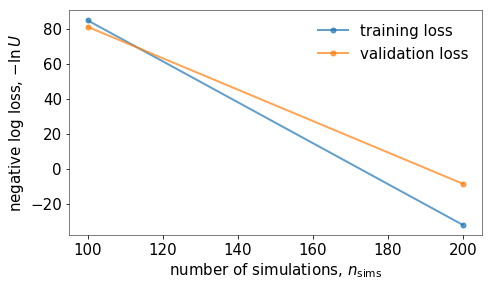

Population 2/10
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


[ 8.21582197e+00  9.07177649e+00  1.06210207e+01  9.30542131e+00
 -7.53215874e+00 -6.59968002e+00 -6.36443466e+00 -5.13144893e+00
  9.20710265e-04 -4.80326371e-01]
[ 8.21582197e+00  9.07177649e+00  1.06210207e+01  9.30542131e+00
 -7.53215874e+00 -6.59968002e+00 -6.36443466e+00 -5.13144893e+00
  9.20710265e-04 -4.80326371e-01]
[ 8.21582197e+00  9.07177649e+00  1.06210207e+01  9.30542131e+00
 -7.53215874e+00 -6.59968002e+00 -6.36443466e+00 -5.13144893e+00
  9.20710265e-04 -4.80326371e-01]
[ 8.01210008e+00  9.31729263e+00  1.08411402e+01  9.41539269e+00
 -7.85726804e+00 -6.64100389e+00 -6.48741264e+00 -5.29559696e+00
  9.12367449e-04 -4.88579679e-01]
[ 8.01210008e+00  9.31729263e+00  1.08411402e+01  9.41539269e+00
 -7.85726804e+00 -6.64100389e+00 -6.48741264e+00 -5.29559696e+00
  9.12367449e-04 -4.88579679e-01]
[ 8.01210008e+00  9.31729263e+00  1.08411402e+01  9.41539269e+00
 -7.85726804e+00 -6.64100389e+00 -6.48741264e+00 -5.29559696e+00
  9.12367449e-04 -4.88579679e-01]
[ 8.01210008e+00

[ 9.38107996e+00  8.27360393e+00  9.29636291e+00  8.07541729e+00
 -6.69244627e+00 -6.02174243e+00 -5.96187272e+00 -6.28092869e+00
  9.29320000e-04 -4.73044149e-01]
[ 9.18387098e+00  8.29625687e+00  1.01688848e+01  8.36891010e+00
 -7.42800236e+00 -5.90701032e+00 -5.38010778e+00 -5.80257686e+00
  9.35471093e-04 -4.61864065e-01]
[ 9.48693819e+00  8.27425745e+00  9.99701771e+00  8.52368574e+00
 -7.22936643e+00 -6.01245045e+00 -5.42112385e+00 -5.60898987e+00
  9.14801620e-04 -4.51541583e-01]
[ 9.66065933e+00  8.07452224e+00  9.84680832e+00  8.49824431e+00
 -6.88984777e+00 -5.96678563e+00 -5.22771979e+00 -5.41534010e+00
  9.19329659e-04 -4.44339280e-01]
[ 9.66065933e+00  8.07452224e+00  9.84680832e+00  8.49824431e+00
 -6.88984777e+00 -5.96678563e+00 -5.22771979e+00 -5.41534010e+00
  9.19329659e-04 -4.44339280e-01]
[ 1.00489731e+01  8.06650702e+00  9.22019504e+00  8.17916971e+00
 -6.59761798e+00 -6.00037546e+00 -5.56288305e+00 -5.50067114e+00
  9.08395228e-04 -4.40282111e-01]
[ 1.00489731e+01

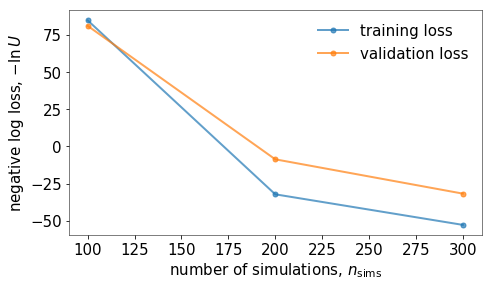

Population 3/10
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


[ 7.87081291e+00  9.03830340e+00  1.12410723e+01  7.58907061e+00
 -3.03169558e+00 -4.89688385e+00 -3.35705064e+00 -2.44645652e+00
  9.75287794e-04 -4.05977810e-01]
[ 8.06995206e+00  8.94809317e+00  1.08250523e+01  7.28076116e+00
 -2.95130397e+00 -5.20814671e+00 -3.53791731e+00 -2.66219134e+00
  1.00173682e-03 -4.20904422e-01]
[ 8.51504809e+00  8.47818001e+00  9.97636228e+00  7.34498406e+00
 -3.34406727e+00 -5.51503053e+00 -3.94606024e+00 -3.44359479e+00
  9.97518428e-04 -4.58110348e-01]
[ 8.51504809e+00  8.47818001e+00  9.97636228e+00  7.34498406e+00
 -3.34406727e+00 -5.51503053e+00 -3.94606024e+00 -3.44359479e+00
  9.97518428e-04 -4.58110348e-01]
[ 8.42588340e+00  8.54497968e+00  1.01696177e+01  7.43290073e+00
 -3.34784224e+00 -5.61889949e+00 -3.91389960e+00 -3.42983841e+00
  1.00313373e-03 -4.61011486e-01]
[ 8.42588340e+00  8.54497968e+00  1.01696177e+01  7.43290073e+00
 -3.34784224e+00 -5.61889949e+00 -3.91389960e+00 -3.42983841e+00
  1.00313373e-03 -4.61011486e-01]
[ 9.56141357e+00

[ 9.72884454e+00  7.72766909e+00  9.79876277e+00  7.03048771e+00
 -3.39990207e+00 -3.75585950e+00 -2.40500042e+00 -2.39438752e+00
  9.83114995e-04 -4.34043029e-01]
[ 9.72884454e+00  7.72766909e+00  9.79876277e+00  7.03048771e+00
 -3.39990207e+00 -3.75585950e+00 -2.40500042e+00 -2.39438752e+00
  9.83114995e-04 -4.34043029e-01]
[ 9.72884454e+00  7.72766909e+00  9.79876277e+00  7.03048771e+00
 -3.39990207e+00 -3.75585950e+00 -2.40500042e+00 -2.39438752e+00
  9.83114995e-04 -4.34043029e-01]
[ 9.72884454e+00  7.72766909e+00  9.79876277e+00  7.03048771e+00
 -3.39990207e+00 -3.75585950e+00 -2.40500042e+00 -2.39438752e+00
  9.83114995e-04 -4.34043029e-01]
[ 9.97081006e+00  7.90733078e+00  1.00364294e+01  7.19344687e+00
 -3.37713879e+00 -3.87317681e+00 -2.24424144e+00 -2.11490469e+00
  1.01040234e-03 -4.35622382e-01]
[ 9.97081006e+00  7.90733078e+00  1.00364294e+01  7.19344687e+00
 -3.37713879e+00 -3.87317681e+00 -2.24424144e+00 -2.11490469e+00
  1.01040234e-03 -4.35622382e-01]
[ 9.97225513e+00

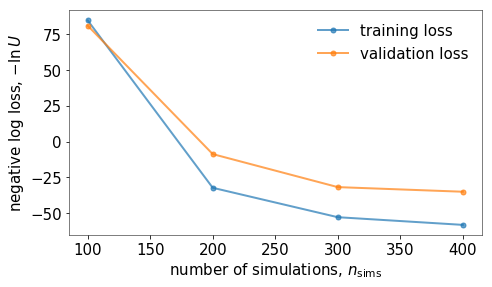

Population 4/10
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


[ 9.14156585e+00  8.33031999e+00  6.04010294e+00  6.03610060e+00
 -2.69762552e+00 -5.98267788e+00 -5.07972944e+00 -3.89802158e+00
  9.08147080e-04 -3.96499572e-01]
[ 9.14156585e+00  8.33031999e+00  6.04010294e+00  6.03610060e+00
 -2.69762552e+00 -5.98267788e+00 -5.07972944e+00 -3.89802158e+00
  9.08147080e-04 -3.96499572e-01]
[ 9.14156585e+00  8.33031999e+00  6.04010294e+00  6.03610060e+00
 -2.69762552e+00 -5.98267788e+00 -5.07972944e+00 -3.89802158e+00
  9.08147080e-04 -3.96499572e-01]
[ 9.14156585e+00  8.33031999e+00  6.04010294e+00  6.03610060e+00
 -2.69762552e+00 -5.98267788e+00 -5.07972944e+00 -3.89802158e+00
  9.08147080e-04 -3.96499572e-01]
[ 9.14156585e+00  8.33031999e+00  6.04010294e+00  6.03610060e+00
 -2.69762552e+00 -5.98267788e+00 -5.07972944e+00 -3.89802158e+00
  9.08147080e-04 -3.96499572e-01]
[ 9.14156585e+00  8.33031999e+00  6.04010294e+00  6.03610060e+00
 -2.69762552e+00 -5.98267788e+00 -5.07972944e+00 -3.89802158e+00
  9.08147080e-04 -3.96499572e-01]
[ 9.14156585e+00

[ 1.00473835e+01  9.15691120e+00  6.20372141e+00  8.05563360e+00
 -2.01373962e+00 -7.33005802e+00 -5.88952865e+00 -4.67506036e+00
  1.00516321e-03 -4.34580532e-01]
[ 1.00473835e+01  9.15691120e+00  6.20372141e+00  8.05563360e+00
 -2.01373962e+00 -7.33005802e+00 -5.88952865e+00 -4.67506036e+00
  1.00516321e-03 -4.34580532e-01]
[ 1.00473835e+01  9.15691120e+00  6.20372141e+00  8.05563360e+00
 -2.01373962e+00 -7.33005802e+00 -5.88952865e+00 -4.67506036e+00
  1.00516321e-03 -4.34580532e-01]
[ 1.00473835e+01  9.15691120e+00  6.20372141e+00  8.05563360e+00
 -2.01373962e+00 -7.33005802e+00 -5.88952865e+00 -4.67506036e+00
  1.00516321e-03 -4.34580532e-01]
[ 1.00473835e+01  9.15691120e+00  6.20372141e+00  8.05563360e+00
 -2.01373962e+00 -7.33005802e+00 -5.88952865e+00 -4.67506036e+00
  1.00516321e-03 -4.34580532e-01]
[ 1.00473835e+01  9.15691120e+00  6.20372141e+00  8.05563360e+00
 -2.01373962e+00 -7.33005802e+00 -5.88952865e+00 -4.67506036e+00
  1.00516321e-03 -4.34580532e-01]
[ 1.00473835e+01

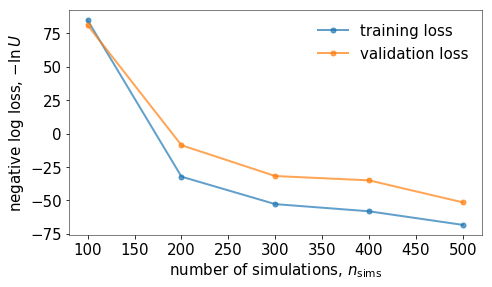

Population 5/10
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


[ 1.05411300e+01  8.83200210e+00  7.90308729e+00  6.06041698e+00
 -3.81610307e+00 -5.04949432e+00 -5.07661251e+00 -2.73030776e+00
  1.16589222e-03 -4.44547587e-01]
[ 1.05411300e+01  8.83200210e+00  7.90308729e+00  6.06041698e+00
 -3.81610307e+00 -5.04949432e+00 -5.07661251e+00 -2.73030776e+00
  1.16589222e-03 -4.44547587e-01]
[ 1.05411300e+01  8.83200210e+00  7.90308729e+00  6.06041698e+00
 -3.81610307e+00 -5.04949432e+00 -5.07661251e+00 -2.73030776e+00
  1.16589222e-03 -4.44547587e-01]
[ 1.05411300e+01  8.83200210e+00  7.90308729e+00  6.06041698e+00
 -3.81610307e+00 -5.04949432e+00 -5.07661251e+00 -2.73030776e+00
  1.16589222e-03 -4.44547587e-01]
[ 1.05411300e+01  8.83200210e+00  7.90308729e+00  6.06041698e+00
 -3.81610307e+00 -5.04949432e+00 -5.07661251e+00 -2.73030776e+00
  1.16589222e-03 -4.44547587e-01]
[ 1.05411300e+01  8.83200210e+00  7.90308729e+00  6.06041698e+00
 -3.81610307e+00 -5.04949432e+00 -5.07661251e+00 -2.73030776e+00
  1.16589222e-03 -4.44547587e-01]
[ 1.05411300e+01

[ 1.12786913e+01  1.15156818e+01  7.05761075e+00  6.17692108e+00
 -4.64768382e+00 -5.94703185e+00 -7.43775613e+00 -3.23112667e+00
  1.07119965e-03 -3.90886235e-01]
[ 1.12786913e+01  1.15156818e+01  7.05761075e+00  6.17692108e+00
 -4.64768382e+00 -5.94703185e+00 -7.43775613e+00 -3.23112667e+00
  1.07119965e-03 -3.90886235e-01]
[ 1.13920486e+01  1.16029927e+01  6.79785947e+00  6.18123622e+00
 -4.71058731e+00 -6.12525095e+00 -7.73595083e+00 -3.25226975e+00
  1.10192520e-03 -3.99025766e-01]
[ 1.13920486e+01  1.16029927e+01  6.79785947e+00  6.18123622e+00
 -4.71058731e+00 -6.12525095e+00 -7.73595083e+00 -3.25226975e+00
  1.10192520e-03 -3.99025766e-01]
[ 1.09449724e+01  1.10140603e+01  7.63133282e+00  6.15864680e+00
 -4.13176849e+00 -6.19675283e+00 -6.79604756e+00 -3.08040148e+00
  1.08457829e-03 -3.94865966e-01]
[ 1.09449724e+01  1.10140603e+01  7.63133282e+00  6.15864680e+00
 -4.13176849e+00 -6.19675283e+00 -6.79604756e+00 -3.08040148e+00
  1.08457829e-03 -3.94865966e-01]
[ 1.10903624e+01

/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


Simulator returns exception for parameter values: [ 1.11096312e+01  1.15078983e+01  7.60951307e+00  6.28709396e+00
 -4.27941878e+00 -6.61982577e+00 -7.05305266e+00 -3.15054266e+00
  1.08312569e-03 -3.87768722e-01] (rank 0)
[ 1.11096312e+01  1.15078983e+01  7.60951307e+00  6.28709396e+00
 -4.27941878e+00 -6.61982577e+00 -7.05305266e+00 -3.15054266e+00
  1.08312569e-03 -3.87768722e-01]
Simulator returns exception for parameter values: [ 1.11096312e+01  1.15078983e+01  7.60951307e+00  6.28709396e+00
 -4.27941878e+00 -6.61982577e+00 -7.05305266e+00 -3.15054266e+00
  1.08312569e-03 -3.87768722e-01] (rank 0)
[ 1.11096312e+01  1.15078983e+01  7.60951307e+00  6.28709396e+00
 -4.27941878e+00 -6.61982577e+00 -7.05305266e+00 -3.15054266e+00
  1.08312569e-03 -3.87768722e-01]
Simulator returns exception for parameter values: [ 1.11096312e+01  1.15078983e+01  7.60951307e+00  6.28709396e+00
 -4.27941878e+00 -6.61982577e+00 -7.05305266e+00 -3.15054266e+00
  1.08312569e-03 -3.87768722e-01] (rank 0)
[ 1

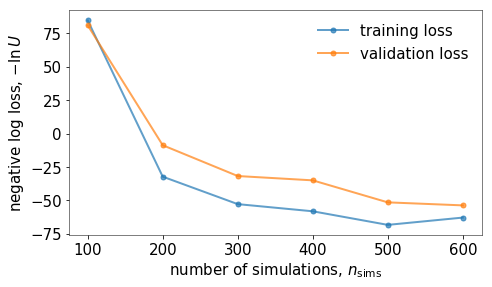

Population 6/10
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


[ 8.92165512e+00  1.16106074e+01  6.92250551e+00  6.62074235e+00
 -5.01994648e+00 -6.11994890e+00 -7.46992485e+00 -2.18459662e+00
  1.06040378e-03 -4.25231214e-01]
[ 8.92165512e+00  1.16106074e+01  6.92250551e+00  6.62074235e+00
 -5.01994648e+00 -6.11994890e+00 -7.46992485e+00 -2.18459662e+00
  1.06040378e-03 -4.25231214e-01]
[ 8.92165512e+00  1.16106074e+01  6.92250551e+00  6.62074235e+00
 -5.01994648e+00 -6.11994890e+00 -7.46992485e+00 -2.18459662e+00
  1.06040378e-03 -4.25231214e-01]
[ 8.92165512e+00  1.16106074e+01  6.92250551e+00  6.62074235e+00
 -5.01994648e+00 -6.11994890e+00 -7.46992485e+00 -2.18459662e+00
  1.06040378e-03 -4.25231214e-01]
[ 8.92165512e+00  1.16106074e+01  6.92250551e+00  6.62074235e+00
 -5.01994648e+00 -6.11994890e+00 -7.46992485e+00 -2.18459662e+00
  1.06040378e-03 -4.25231214e-01]
[ 8.92165512e+00  1.16106074e+01  6.92250551e+00  6.62074235e+00
 -5.01994648e+00 -6.11994890e+00 -7.46992485e+00 -2.18459662e+00
  1.06040378e-03 -4.25231214e-01]
[ 8.41140340e+00

[ 9.27309903e+00  1.15876577e+01  7.39239639e+00  6.59608762e+00
 -4.21840121e+00 -5.56649794e+00 -7.04737625e+00 -2.32141558e+00
  1.02374161e-03 -4.02070405e-01]
[ 9.27309903e+00  1.15876577e+01  7.39239639e+00  6.59608762e+00
 -4.21840121e+00 -5.56649794e+00 -7.04737625e+00 -2.32141558e+00
  1.02374161e-03 -4.02070405e-01]
[ 9.29714028e+00  1.16259620e+01  7.63684201e+00  6.57574913e+00
 -4.49972964e+00 -5.58496409e+00 -7.03735722e+00 -2.29134157e+00
  1.02364897e-03 -4.02102693e-01]
[ 9.29714028e+00  1.16259620e+01  7.63684201e+00  6.57574913e+00
 -4.49972964e+00 -5.58496409e+00 -7.03735722e+00 -2.29134157e+00
  1.02364897e-03 -4.02102693e-01]
[ 9.37149931e+00  1.15147257e+01  7.57730005e+00  6.55260084e+00
 -4.47710692e+00 -5.57577701e+00 -7.07083374e+00 -2.33300451e+00
  1.01966227e-03 -4.00117586e-01]
[ 9.29013530e+00  1.15229634e+01  7.53255719e+00  6.53282398e+00
 -4.54752201e+00 -5.60286730e+00 -7.02743634e+00 -2.25587696e+00
  1.01814972e-03 -3.99025408e-01]
[ 9.29013530e+00

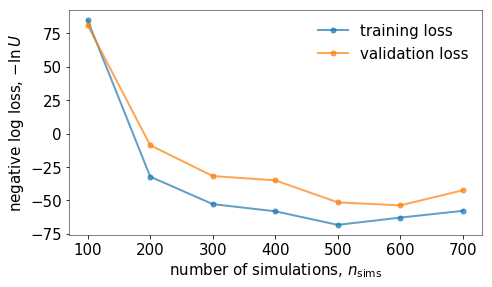

Population 7/10
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


[ 8.36982915e+00  1.02397660e+01  9.05751257e+00  6.52608431e+00
 -2.48647285e+00 -5.12866305e+00 -7.23342175e+00 -2.52846178e+00
  9.69200188e-04 -3.77203343e-01]
[ 8.36982915e+00  1.02397660e+01  9.05751257e+00  6.52608431e+00
 -2.48647285e+00 -5.12866305e+00 -7.23342175e+00 -2.52846178e+00
  9.69200188e-04 -3.77203343e-01]
[ 8.99618148e+00  1.05641799e+01  8.82387193e+00  7.20443830e+00
 -3.06108500e+00 -4.85978557e+00 -7.24423852e+00 -2.44198428e+00
  9.60079171e-04 -3.70341993e-01]
[ 8.55895055e+00  1.02987382e+01  8.84286607e+00  6.73387632e+00
 -2.50408533e+00 -4.69599979e+00 -7.25281415e+00 -2.44310307e+00
  9.73924517e-04 -3.76790062e-01]
[ 8.55895055e+00  1.02987382e+01  8.84286607e+00  6.73387632e+00
 -2.50408533e+00 -4.69599979e+00 -7.25281415e+00 -2.44310307e+00
  9.73924517e-04 -3.76790062e-01]
[ 8.77712369e+00  1.04404395e+01  9.08716850e+00  7.05148059e+00
 -3.07458403e+00 -4.88305214e+00 -7.14422380e+00 -2.54505132e+00
  9.54264309e-04 -3.68823262e-01]
[ 8.77712369e+00

[ 8.35875835e+00  1.04848203e+01  1.05770729e+01  6.40149648e+00
 -3.07199100e+00 -6.13064207e+00 -6.39156343e+00 -2.52444638e+00
  9.02130936e-04 -3.29108943e-01]
[ 8.35875835e+00  1.04848203e+01  1.05770729e+01  6.40149648e+00
 -3.07199100e+00 -6.13064207e+00 -6.39156343e+00 -2.52444638e+00
  9.02130936e-04 -3.29108943e-01]
[ 8.81701309e+00  1.04250103e+01  1.02577048e+01  6.68636298e+00
 -3.28407254e+00 -5.98540833e+00 -6.07667678e+00 -2.52454797e+00
  8.89242880e-04 -3.21588292e-01]
[ 8.81701309e+00  1.04250103e+01  1.02577048e+01  6.68636298e+00
 -3.28407254e+00 -5.98540833e+00 -6.07667678e+00 -2.52454797e+00
  8.89242880e-04 -3.21588292e-01]
[ 8.81701309e+00  1.04250103e+01  1.02577048e+01  6.68636298e+00
 -3.28407254e+00 -5.98540833e+00 -6.07667678e+00 -2.52454797e+00
  8.89242880e-04 -3.21588292e-01]
[ 9.26596042e+00  1.06755466e+01  9.82611659e+00  6.73258344e+00
 -3.33283957e+00 -5.79116582e+00 -6.15057956e+00 -2.52098897e+00
  9.05790433e-04 -3.29661215e-01]
[ 9.26596042e+00

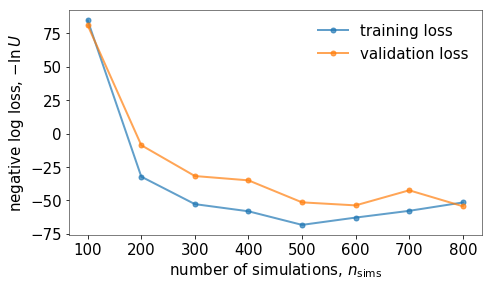

Population 8/10
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


[ 9.83449554e+00  1.03825146e+01  9.21024745e+00  7.77934460e+00
 -5.45911731e+00 -5.42788818e+00 -6.30019503e+00 -2.36053454e+00
  1.03653906e-03 -3.94434013e-01]
[ 9.83449554e+00  1.03825146e+01  9.21024745e+00  7.77934460e+00
 -5.45911731e+00 -5.42788818e+00 -6.30019503e+00 -2.36053454e+00
  1.03653906e-03 -3.94434013e-01]
[ 9.64724233e+00  1.08200041e+01  9.47444877e+00  8.14830347e+00
 -5.92456626e+00 -6.43570210e+00 -6.61830525e+00 -2.50984066e+00
  1.06662512e-03 -4.03911152e-01]
[ 9.89650575e+00  1.10483152e+01  9.23766569e+00  8.15889000e+00
 -6.28259995e+00 -7.02431801e+00 -7.20590645e+00 -2.48194059e+00
  1.07452311e-03 -4.10514868e-01]
[ 9.81748489e+00  1.11341939e+01  9.22100355e+00  8.03440724e+00
 -6.01402867e+00 -6.95935654e+00 -7.16164464e+00 -2.54767284e+00
  1.05752030e-03 -4.04005951e-01]
[ 9.81748489e+00  1.11341939e+01  9.22100355e+00  8.03440724e+00
 -6.01402867e+00 -6.95935654e+00 -7.16164464e+00 -2.54767284e+00
  1.05752030e-03 -4.04005951e-01]
[ 9.81748489e+00

[ 9.68470354e+00  1.16311981e+01  9.70144831e+00  8.60118516e+00
 -5.79672030e+00 -6.77354869e+00 -7.32558654e+00 -2.21395163e+00
  1.02939296e-03 -3.97262122e-01]
[ 9.68470354e+00  1.16311981e+01  9.70144831e+00  8.60118516e+00
 -5.79672030e+00 -6.77354869e+00 -7.32558654e+00 -2.21395163e+00
  1.02939296e-03 -3.97262122e-01]
[ 9.68470354e+00  1.16311981e+01  9.70144831e+00  8.60118516e+00
 -5.79672030e+00 -6.77354869e+00 -7.32558654e+00 -2.21395163e+00
  1.02939296e-03 -3.97262122e-01]
[ 9.68470354e+00  1.16311981e+01  9.70144831e+00  8.60118516e+00
 -5.79672030e+00 -6.77354869e+00 -7.32558654e+00 -2.21395163e+00
  1.02939296e-03 -3.97262122e-01]
[ 9.68470354e+00  1.16311981e+01  9.70144831e+00  8.60118516e+00
 -5.79672030e+00 -6.77354869e+00 -7.32558654e+00 -2.21395163e+00
  1.02939296e-03 -3.97262122e-01]
[ 9.68470354e+00  1.16311981e+01  9.70144831e+00  8.60118516e+00
 -5.79672030e+00 -6.77354869e+00 -7.32558654e+00 -2.21395163e+00
  1.02939296e-03 -3.97262122e-01]
[ 9.68470354e+00

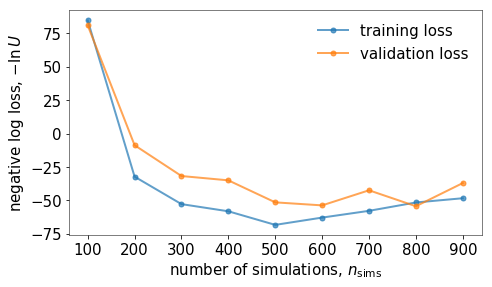

Population 9/10
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


[ 9.82670816e+00  1.19033686e+01  6.61040095e+00  7.71678222e+00
 -5.56124237e+00 -5.54825210e+00 -7.94988083e+00 -2.05660468e+00
  1.08878357e-03 -4.23198896e-01]
[ 9.82670816e+00  1.19033686e+01  6.61040095e+00  7.71678222e+00
 -5.56124237e+00 -5.54825210e+00 -7.94988083e+00 -2.05660468e+00
  1.08878357e-03 -4.23198896e-01]
[ 9.82670816e+00  1.19033686e+01  6.61040095e+00  7.71678222e+00
 -5.56124237e+00 -5.54825210e+00 -7.94988083e+00 -2.05660468e+00
  1.08878357e-03 -4.23198896e-01]
[ 9.82670816e+00  1.19033686e+01  6.61040095e+00  7.71678222e+00
 -5.56124237e+00 -5.54825210e+00 -7.94988083e+00 -2.05660468e+00
  1.08878357e-03 -4.23198896e-01]
[ 9.82670816e+00  1.19033686e+01  6.61040095e+00  7.71678222e+00
 -5.56124237e+00 -5.54825210e+00 -7.94988083e+00 -2.05660468e+00
  1.08878357e-03 -4.23198896e-01]
[ 9.82670816e+00  1.19033686e+01  6.61040095e+00  7.71678222e+00
 -5.56124237e+00 -5.54825210e+00 -7.94988083e+00 -2.05660468e+00
  1.08878357e-03 -4.23198896e-01]
[ 9.82670816e+00

/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


[ 9.60602102e+00  1.12034880e+01  7.07359320e+00  7.78467028e+00
 -6.19966906e+00 -5.73220304e+00 -7.25019082e+00 -2.08818027e+00
  1.02893140e-03 -3.94683515e-01]
[ 9.61671625e+00  1.11963377e+01  7.08085057e+00  7.78738295e+00
 -6.17948200e+00 -5.72443168e+00 -7.23664088e+00 -2.09116106e+00
  1.02756677e-03 -3.94186278e-01]
Simulator returns exception for parameter values: [ 9.61671625e+00  1.11963377e+01  7.08085057e+00  7.78738295e+00
 -6.17948200e+00 -5.72443168e+00 -7.23664088e+00 -2.09116106e+00
  1.02756677e-03 -3.94186278e-01] (rank 0)
[ 9.55104658e+00  1.12402411e+01  7.03628966e+00  7.77072694e+00
 -6.30343239e+00 -5.77214851e+00 -7.31983872e+00 -2.07285877e+00
  1.03594571e-03 -3.97239358e-01]
[ 9.55104658e+00  1.12402411e+01  7.03628966e+00  7.77072694e+00
 -6.30343239e+00 -5.77214851e+00 -7.31983872e+00 -2.07285877e+00
  1.03594571e-03 -3.97239358e-01]
[ 9.63340146e+00  1.13186875e+01  8.58625584e+00  7.09689946e+00
 -4.57028748e+00 -5.72088960e+00 -6.82943978e+00 -2.5230

[ 8.72059944e+00  1.07451981e+01  9.77928975e+00  6.07067009e+00
 -4.59722681e+00 -6.08283133e+00 -6.48058059e+00 -2.32214441e+00
  1.12486402e-03 -4.23635915e-01]
[ 8.72059944e+00  1.07451981e+01  9.77928975e+00  6.07067009e+00
 -4.59722681e+00 -6.08283133e+00 -6.48058059e+00 -2.32214441e+00
  1.12486402e-03 -4.23635915e-01]
[ 8.72059944e+00  1.07451981e+01  9.77928975e+00  6.07067009e+00
 -4.59722681e+00 -6.08283133e+00 -6.48058059e+00 -2.32214441e+00
  1.12486402e-03 -4.23635915e-01]
[ 8.72059944e+00  1.07451981e+01  9.77928975e+00  6.07067009e+00
 -4.59722681e+00 -6.08283133e+00 -6.48058059e+00 -2.32214441e+00
  1.12486402e-03 -4.23635915e-01]
[ 9.27477640e+00  1.05163830e+01  9.23732717e+00  6.21904894e+00
 -3.93120083e+00 -5.81061390e+00 -6.16898739e+00 -2.38947155e+00
  1.05240995e-03 -3.99676297e-01]
[ 9.27477640e+00  1.05163830e+01  9.23732717e+00  6.21904894e+00
 -3.93120083e+00 -5.81061390e+00 -6.16898739e+00 -2.38947155e+00
  1.05240995e-03 -3.99676297e-01]
[ 9.27477640e+00

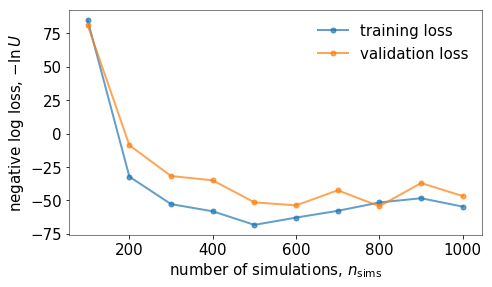

Population 10/10
Sampling proposal density...


/afs/inf.ed.ac.uk/user/s18/s1832582/.conda/envs/thesis/lib/python3.7/site-packages/pydelfi/delfi.py:224: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.


[ 9.06965332e+00  8.34314874e+00  8.18458479e+00  6.60536542e+00
 -2.91919313e+00 -4.45313406e+00 -3.92698838e+00 -2.15116678e+00
  8.12435834e-04 -2.99065910e-01]
[ 8.99253720e+00  8.01834533e+00  8.24797019e+00  6.59261321e+00
 -2.72279137e+00 -4.38542531e+00 -3.56618152e+00 -2.11925114e+00
  7.98360257e-04 -2.91931005e-01]
[ 8.99253720e+00  8.01834533e+00  8.24797019e+00  6.59261321e+00
 -2.72279137e+00 -4.38542531e+00 -3.56618152e+00 -2.11925114e+00
  7.98360257e-04 -2.91931005e-01]
[ 8.99253720e+00  8.01834533e+00  8.24797019e+00  6.59261321e+00
 -2.72279137e+00 -4.38542531e+00 -3.56618152e+00 -2.11925114e+00
  7.98360257e-04 -2.91931005e-01]
[ 8.99253720e+00  8.01834533e+00  8.24797019e+00  6.59261321e+00
 -2.72279137e+00 -4.38542531e+00 -3.56618152e+00 -2.11925114e+00
  7.98360257e-04 -2.91931005e-01]
[ 8.99253720e+00  8.01834533e+00  8.24797019e+00  6.59261321e+00
 -2.72279137e+00 -4.38542531e+00 -3.56618152e+00 -2.11925114e+00
  7.98360257e-04 -2.91931005e-01]
[ 9.41442277e+00

[ 8.56552151e+00  7.74897346e+00  7.90148637e+00  7.04821476e+00
 -2.83118035e+00 -2.96785288e+00 -2.43799482e+00 -2.08700751e+00
  7.46258972e-04 -2.82480426e-01]
[ 8.76824483e+00  8.21462845e+00  8.02220635e+00  6.91204976e+00
 -3.20100620e+00 -3.60958091e+00 -3.18570983e+00 -2.13932991e+00
  7.88293931e-04 -2.98918461e-01]
[ 8.76824483e+00  8.21462845e+00  8.02220635e+00  6.91204976e+00
 -3.20100620e+00 -3.60958091e+00 -3.18570983e+00 -2.13932991e+00
  7.88293931e-04 -2.98918461e-01]
[ 8.76824483e+00  8.21462845e+00  8.02220635e+00  6.91204976e+00
 -3.20100620e+00 -3.60958091e+00 -3.18570983e+00 -2.13932991e+00
  7.88293931e-04 -2.98918461e-01]
[ 8.77678462e+00  8.31733466e+00  8.02107077e+00  6.90017130e+00
 -3.27927691e+00 -3.70042044e+00 -3.31673007e+00 -2.14361421e+00
  7.89949671e-04 -2.99873114e-01]
[ 8.77678462e+00  8.31733466e+00  8.02107077e+00  6.90017130e+00
 -3.27927691e+00 -3.70042044e+00 -3.31673007e+00 -2.14361421e+00
  7.89949671e-04 -2.99873114e-01]
[ 8.77678462e+00

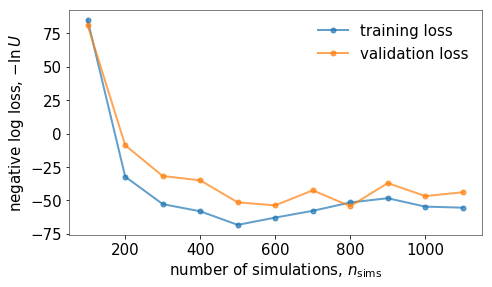

In [10]:
n_initial = 100
n_batch = 100
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20., save_intermediate_posteriors=False, simulator_args=simulator_args)

## Sample the learned posterior

[ 9.08854753e+00  8.69627986e+00  8.13029702e+00  7.38469681e+00
 -4.04980639e+00 -3.99417270e+00 -4.16045830e+00 -3.03982731e+00
  9.33771472e-04 -3.37522792e-01]


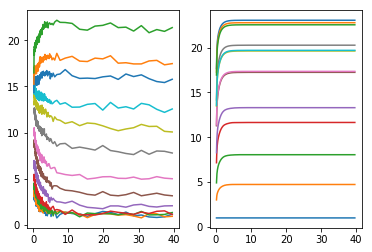

In [18]:
#pst = DelfiEnsemble.emcee_sample()
time = np.genfromtxt('simulators/faas/data/time_points.csv', delimiter=',')
sims = simulator(pst1[49], seed, simulator_args, 0)
data = faasSimulator.data()[batch_min:batch_max,:]

print(pst[49])
fig,ax = plt.subplots(1,2) 

for i in range(len(sims)):
    ax[0].plot(time, data[i])
    ax[1].plot(time, sims[i])


plt.show()

In [15]:
#pst = np.unique(pst, axis=0)
pst1 = pst[np.abs(pst[:,0]) < 13] #Discard any obviously wrong samples (write better func to do this)
print(pst1.shape)

(46393, 10)


In [ ]:
plt.scatter(np.log(pst[0,:]), np.log(pst[3,:]))
plt.show()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


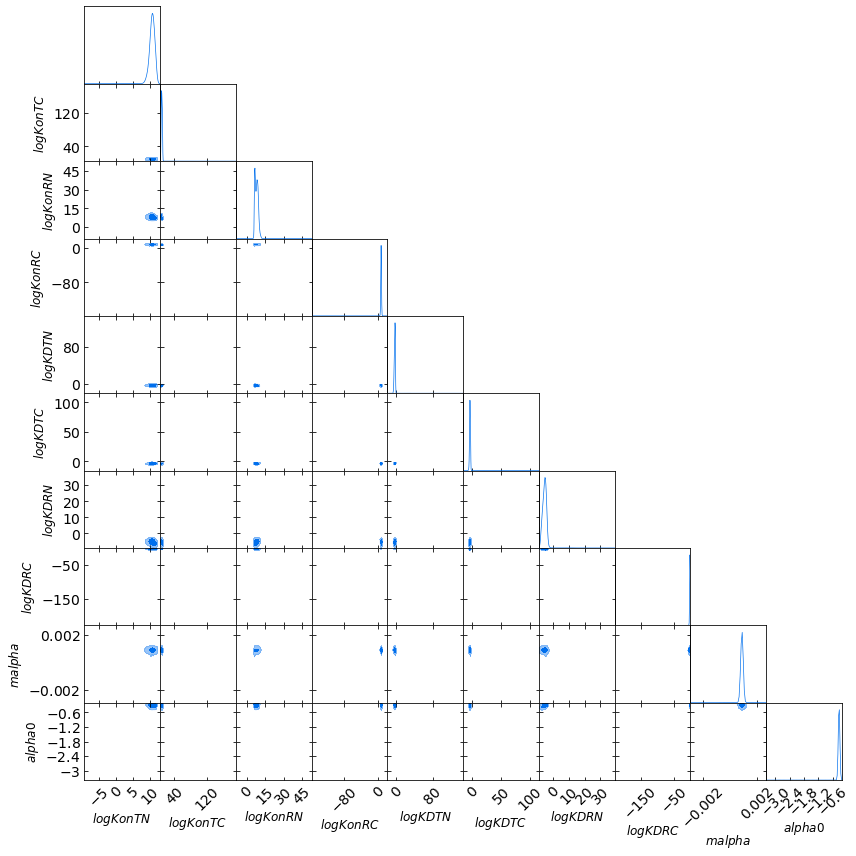

In [16]:
DelfiEnsemble.triangle_plot(samples=[pst1], savefig=True, filename='batch_E.pdf')

## Calibration

In [ ]:
rank = np.zeros(10,9)

for i in range(N):
    ps = prior.draw()
    sims = simulator(ps, 0, simulator_args, 1)
    DelfiEnsemble = delfi.Delfi(sims, prior, NDEs, 
                       param_limits = [lower, upper],
                       param_names = ['logK_on_TN', 'logK_on_TC', 'logK_on_RN', 'logK_on_RC', 'logK_D_TN', 'logK_D_TC', 'logK_D_RN', 'logK_D_RC', 'm_alpha', 'alpha0'],
                       results_dir = "simulators/faas/calib/", save = False)

    
    
    n_initial = 100
    n_batch = 10
    n_populations = 1

    DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=2., save_intermediate_posteriors=False, simulator_args=simulator_args)
    pst = DelfiEnsemble.emcee_sample()[:9]
    for j in range(18):
        for l in range(9):
            rank[j,l] += np.sum(pst[l][j] < ps[j])
        
    
        

